### [GLM: Linear regression](https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-linear.html)

In [8]:
import arviz
import pymc3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_SEED = 8927
rng = np.random.default_rng(seed=RANDOM_SEED)
arviz.style.use('arviz-darkgrid')

In [45]:
def generate_data(size: int = 200, intercept: float = 1.0, slope: float = 2.0):
    x = np.linspace(0, 1, size)
    y = intercept + slope * x + rng.normal(scale=0.5, size=size)
    return pd.DataFrame.from_dict({'x': x, 'y': y})

p = 1.0
m = 2.0
data = generate_data(slope=m, intercept=p)

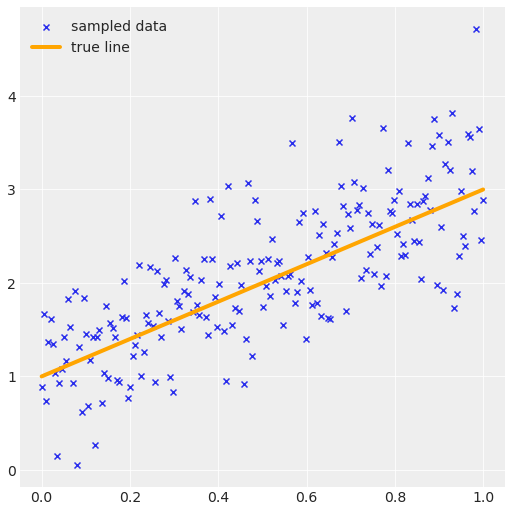

In [18]:
xp = np.array([0, 1])
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(data.x, data.y, marker='x', label='sampled data')
ax.plot(xp, p + m * xp, lw=4, color='orange', label='true line')
ax.legend()

plt.show()

In [34]:
with pymc3.Model() as model:
    # priors
    sigma = pymc3.HalfCauchy('sigma', beta=10, testval=1.0)
    intercept = pymc3.Normal('Intercept', 0, sigma=20)
    x_coeff = pymc3.Normal('x', 0, sigma=20)

    # likelihood
    likelihood = pymc3.Normal(
        'y',
        mu=intercept + x_coeff * data['x'],
        sigma=sigma,
        observed=data['y'],
        )

In [35]:
with model:
    trace = pymc3.sample(3_000, return_inferencedata=True, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [x, Intercept, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 15 seconds.
The acceptance probability does not match the target. It is 0.8854740646640334, but should be close to 0.8. Try to increase the number of tuning steps.


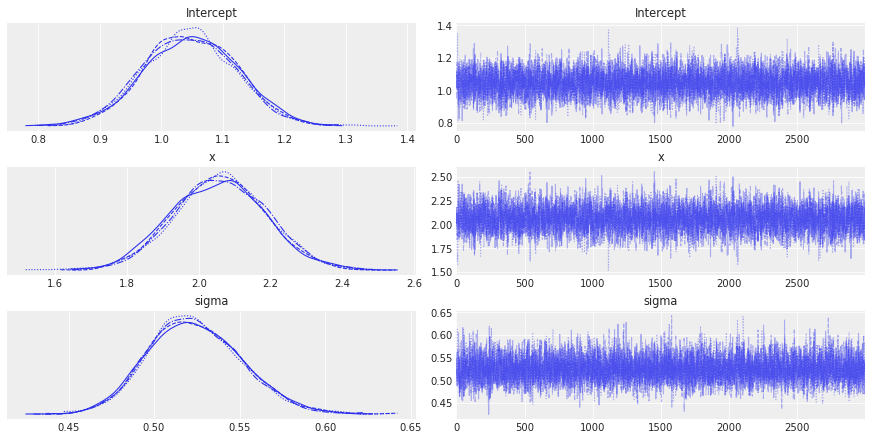

In [36]:
arviz.plot_trace(trace)
plt.show()

/home/DKS0559531/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/pymc3/plots/posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(


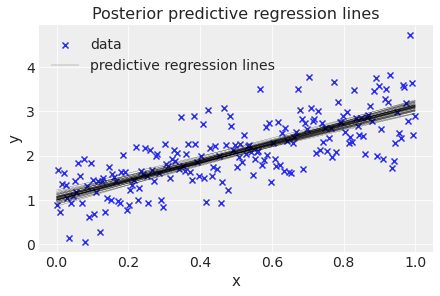

In [43]:
fig, ax = plt.subplots()

ax.scatter(data['x'], data['y'], marker='x', label='data')
pymc3.plot_posterior_predictive_glm(trace, samples=50, label="predictive regression lines")
ax.set(
    title="Posterior predictive regression lines",
    xlabel="x",
    ylabel="y",
)
ax.legend()

plt.show()

### [Hierarchical GLM](https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM.html)



In [54]:
import arviz
import pymc3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_SEED = 8927
rng = np.random.default_rng(seed=RANDOM_SEED)
arviz.style.use('arviz-darkgrid')

In [61]:
def generate_data(size: int = 50, intercept: float = 1.0, slope: float = 2.0):
    x = np.linspace(0, 1, size)
    y = intercept + slope * x + rng.normal(scale=0.5, size=size)
    return pd.DataFrame.from_dict({'x': x, 'y': y})

m = 2.0
p = 1.0
data = generate_data(intercept=p, slope=m)
# add some outliers
outliers_dict = {'x': [0.1, 0.15, 0.2], 'y': [8, 6, 9]}
data = pd.concat(
    [
        data,
        pd.DataFrame.from_dict(outliers_dict)],
    axis=0,
)

with pymc3.Model() as model:
     # priors
    y_sigma = pymc3.HalfStudentT('y_sigma', sigma=10, nu=10)
    intercept = pymc3.Normal('Intercept', 0, sigma=20)
    x_coeff = pymc3.Normal('x', 0, sigma=20)

    # likelihood
    likelihood = pymc3.Normal(
        'y',
        mu=intercept + x_coeff * data['x'],
        sigma=y_sigma,
        observed=data['y'],
        )

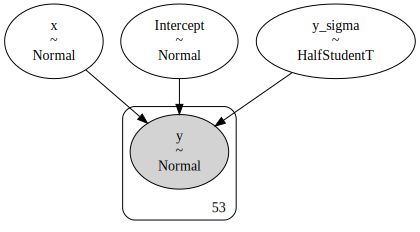

In [62]:
pymc3.model_to_graphviz(model)

In [63]:
with model:
    trace = pymc3.sample(3_000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [x, Intercept, y_sigma]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 6 seconds.


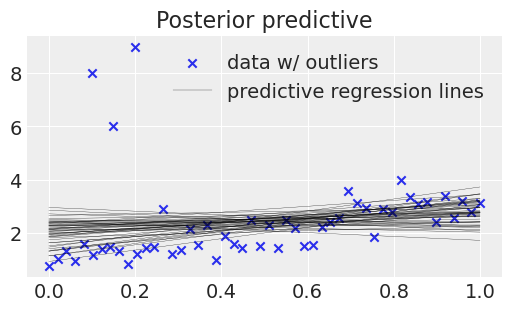

In [72]:
fig, ax = plt.subplots(figsize=(5,3))

ax.scatter(data['x'], data['y'], marker='x', label="data w/ outliers")
pymc3.plot_posterior_predictive_glm(trace, samples=50, label="predictive regression lines")

ax.legend()
plt.show()

The Student's-T distribution has heavier tails and so is more robust to outliers. We can try using this as our likelihood function. 

In [85]:
with pymc3.Model() as robust_model:
     # priors
    y_sigma = pymc3.HalfStudentT('y_sigma', sigma=10, nu=10)
    intercept = pymc3.Normal('Intercept', 0, sigma=20)
    x_coeff = pymc3.Normal('x', 0, sigma=20)  # slope

    # likelihood
    # "StudentT", (lam=1, nu=1.5)
    likelihood = pymc3.StudentT(
        'y',
        mu=intercept + x_coeff * data['x'],
        lam=1,
        nu=1.5,
        observed=data['y'],
        )

    trace = pymc3.sample(3_000)

/tmp/ipykernel_6918/4210223021.py:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pymc3.sample(3_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [x, Intercept, y_sigma]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 8 seconds.


/home/DKS0559531/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/pymc3/plots/posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(


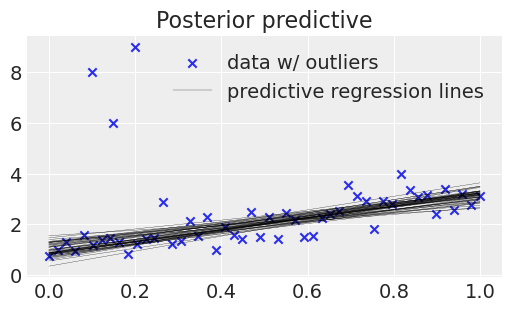

In [86]:
fig, ax = plt.subplots(figsize=(5,3))

ax.scatter(data['x'], data['y'], marker='x', label="data w/ outliers")
pymc3.plot_posterior_predictive_glm(trace, samples=50, label="predictive regression lines")

ax.legend()
plt.show()

In [97]:
slope_trace = trace.get_values('x')
intercept_trace = trace.get_values('Intercept')

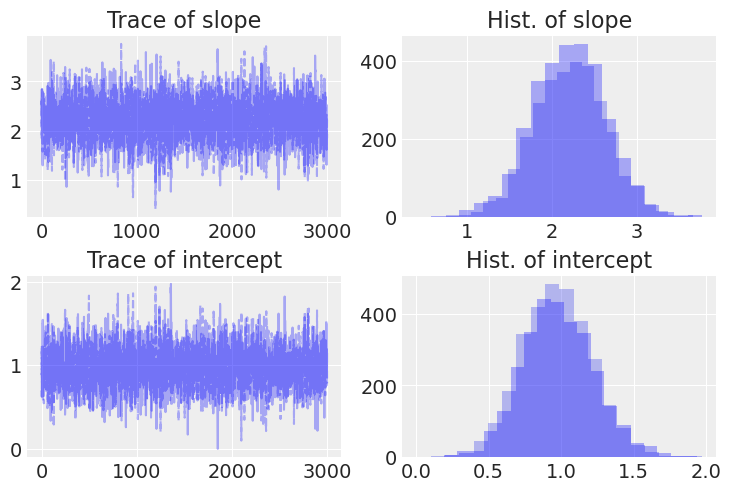

In [110]:
fig, ax = plt.subplots(nrows=2, ncols=2)

props_chain1 = {'color': 'b', 'alpha': 0.3}
props_chain2 = {'color': 'b', 'linestyle': '--', 'alpha': 0.3}

ax[0,0].plot(slope_trace[:3000], **props_chain1)
ax[0,0].plot(slope_trace[3000:], **props_chain2)
ax[0,0].set(title="Trace of slope")

ax[1,0].plot(intercept_trace[:3000], **props_chain1)
ax[1,0].plot(intercept_trace[3000:], **props_chain2)
ax[1,0].set(title="Trace of intercept")

ax[0,1].hist(slope_trace[:3000], bins=20, alpha=0.3)
ax[0,1].hist(slope_trace[3000:], color='b', bins=20, alpha=0.3)
ax[0,1].set(title="Hist. of slope")

ax[1,1].hist(intercept_trace[:3000], bins=20, alpha=0.3)
ax[1,1].hist(intercept_trace[3000:], color='b', bins=20, alpha=0.3)
ax[1,1].set(title="Hist. of intercept")

plt.show()

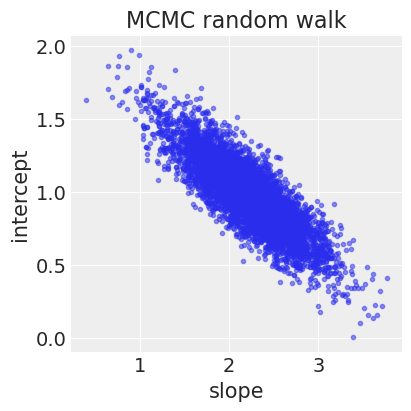

In [117]:
fig, ax = plt.subplots(figsize=(4,4))

ax.scatter(slope_trace, intercept_trace, marker='.', alpha=0.5)
ax.set(xlabel='slope', ylabel='intercept', title="MCMC random walk")
plt.show()